<h1> Exploring and creating ML datasets </h1>

In this notebook, we will explore data corresponding to taxi rides in New York City to build a Machine Learning model in support of a fare-estimation tool. The idea is to suggest a likely fare to taxi riders so that they are not surprised, and so that they can protest if the charge is much higher than expected.

Let's start off with the Python imports that we need.

In [24]:
import datalab.bigquery as bq
import seaborn as sns
import pandas as pd
import numpy as np
import shutil

<h3> Extract sample data from BigQuery </h3>

The dataset that we will use is <a href="https://bigquery.cloud.google.com/table/nyc-tlc:yellow.trips">a BigQuery public dataset</a>. Click on the link, and look at the column names. Switch to the Details tab to verify that the number of records is one billion, and then switch to the Preview tab to look at a few rows.

Let's write a SQL query to pick up interesting fields from the dataset.

In [25]:
%sql --module afewrecords
SELECT pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude,
dropoff_latitude, passenger_count, trip_distance, tolls_amount, 
fare_amount, total_amount FROM [nyc-tlc:yellow.trips] LIMIT 10

In [26]:
trips = bq.Query(afewrecords).to_dataframe()
trips

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
0,2013-08-06 01:46:00,0.000000,0.000000,0.000000,0.000000,2,0.00,0.0,0.0,0.0
1,2013-08-16 09:30:00,0.000000,0.000000,0.000000,0.000000,1,0.00,0.0,0.0,0.0
2,2009-03-08 18:40:00,-73.995678,40.761357,-73.995678,40.761357,1,0.00,0.0,2.5,2.5
3,2009-07-10 12:43:00,-73.974562,40.759975,-73.974552,40.759992,1,0.00,0.0,2.5,2.5
4,2009-06-07 11:06:00,-74.001473,40.730443,-74.001498,40.730877,1,0.03,0.0,2.5,2.5
5,2009-07-12 16:52:36,-74.065468,40.738396,-74.177705,40.695399,1,9.20,0.0,2.5,2.5
6,2009-04-01 15:19:38,-73.983387,40.762971,-73.982605,40.762810,1,0.00,0.0,2.5,2.5
7,2009-01-08 12:18:00,-73.776750,40.645362,-73.776770,40.645457,1,0.02,0.0,2.5,2.5
8,2009-09-12 18:19:00,-73.952593,40.772168,-73.954580,40.772850,2,0.13,0.0,2.5,2.5
9,2009-10-16 12:44:06,-73.978246,40.762379,-73.959248,40.783205,1,2.00,0.0,2.5,2.5


Let's increase the number of records so that we can do some neat graphs.  There is no guarantee about the order in which records are returned, and so no guarantee about which records get returned if we simply increase the LIMIT. To properly sample the dataset, let's use the HASH of the pickup time and return 1 in 100,000 records -- because there are 1 billion records in the data, we should get back approximately 10,000 records if we do this.

In [27]:
%sql --module afewrecords2
SELECT
  pickup_datetime,
  pickup_longitude, pickup_latitude, 
  dropoff_longitude, dropoff_latitude,
  passenger_count,
  trip_distance,
  tolls_amount,
  fare_amount,
  total_amount
FROM
  [nyc-tlc:yellow.trips]
WHERE
  ABS(HASH(pickup_datetime)) % $EVERY_N == 1

In [28]:
trips = bq.Query(afewrecords2, EVERY_N=100000).to_dataframe()
trips[:10]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
0,2013-09-09 19:29:00,-73.978865,40.747827,-73.990802,40.734872,1,1.22,0.0,6.0,8.9
1,2014-02-04 11:12:00,-73.981118,40.737560,-73.996475,40.736355,1,1.13,0.0,8.0,9.0
2,2013-01-13 23:28:00,-73.987270,40.756152,-74.006050,40.724175,2,2.68,0.0,10.0,11.0
3,2014-12-22 21:17:00,-73.990767,40.734272,-73.981447,40.758317,1,2.16,0.0,10.0,13.1
4,2014-02-04 11:12:00,-73.981238,40.774165,-73.973605,40.753682,1,1.98,0.0,12.5,15.5
5,2014-02-04 11:12:00,-73.988337,40.748887,-74.003277,40.756272,1,1.28,0.0,13.5,14.0
6,2014-02-04 11:12:00,-74.008997,40.706082,-73.975172,40.741497,1,4.89,0.0,16.0,18.5
7,2013-01-13 23:28:00,-73.999180,40.724957,-73.971925,40.764725,1,4.42,0.0,16.0,20.3
8,2011-09-28 21:18:00,-73.981088,40.753278,-73.980968,40.753182,2,0.03,0.0,2.9,3.9
9,2012-02-15 09:06:00,-73.990115,40.731930,-74.006380,40.720525,1,1.87,0.0,8.1,9.6


<h3> Exploring data </h3>

Let's explore this dataset and clean it up as necessary. We'll use the Python Seaborn package to visualize graphs and Pandas to do the slicing and filtering.

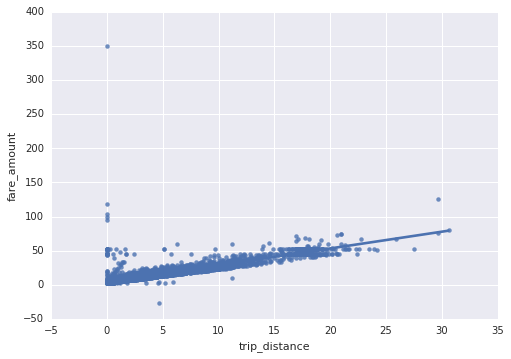

In [29]:
ax = sns.regplot(x="trip_distance", y="fare_amount", ci=None, truncate=True, data=trips)

Hmm ... do you see something wrong with the data that needs addressing?

It appears that we have a lot of invalid data that is being coded as zero distance and some fare amounts that are definitely illegitimate. Let's remove them from our analysis. We can do this by modifying the BigQuery query to keep only trips longer than zero miles and fare amounts that are at least the minimum cab fare ($2.50).

Note the extra WHERE clauses.

In [30]:
%sql --module afewrecords3
SELECT
  pickup_datetime,
  pickup_longitude, pickup_latitude, 
  dropoff_longitude, dropoff_latitude,
  passenger_count,
  trip_distance,
  tolls_amount,
  fare_amount,
  total_amount
FROM
  [nyc-tlc:yellow.trips]
WHERE
  (ABS(HASH(pickup_datetime)) % $EVERY_N == 1 AND
  trip_distance > 0 AND fare_amount >= 2.5)

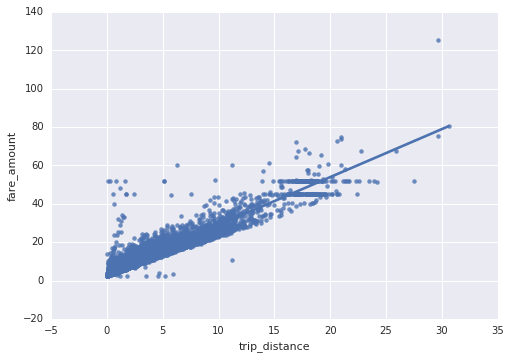

In [31]:
trips = bq.Query(afewrecords3, EVERY_N=100000).to_dataframe()
ax = sns.regplot(x="trip_distance", y="fare_amount", ci=None, truncate=True, data=trips)

What's up with the streaks at $45 and $50?  Those are fixed-amount rides from JFK and La Guardia airports into anywhere in Manhattan, i.e. to be expected. Let's list the data to make sure the values look reasonable

In [32]:
trips[:10]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
0,2013-11-16 10:19:00,-73.967945,40.754872,-73.967165,40.754477,1,0.07,0.0,2.5,3.00
1,2009-02-20 02:37:00,-73.985015,40.758678,-73.972948,40.755998,1,0.88,0.0,4.5,5.00
2,2013-10-20 13:41:00,-73.962867,40.766732,-73.948390,40.770617,1,1.19,0.0,6.5,7.00
3,2013-10-20 13:41:00,-73.974862,40.756872,-73.959877,40.771207,1,1.33,0.0,7.5,9.50
4,2013-11-16 10:19:00,-74.001767,40.719287,-73.987735,40.749717,1,2.45,0.0,9.5,10.00
5,2012-08-07 15:57:00,-73.967357,40.771042,-73.986727,40.755150,5,2.36,0.0,10.5,11.00
6,2014-10-05 11:46:00,-73.999077,40.734272,-73.967680,40.760342,1,2.94,0.0,12.0,14.90
7,2014-12-22 21:17:00,-73.990558,40.739310,-73.964525,40.772675,5,2.96,0.0,13.0,16.70
8,2012-08-07 15:57:00,-73.984270,40.737152,-73.996102,40.748507,2,1.29,0.0,7.3,7.80
9,2012-08-11 01:35:00,-73.978352,40.679620,-73.999255,40.684090,1,1.61,0.0,6.1,8.42


In [33]:
trips.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
count,11400.000000,11400.000000,11400.000000,11400.000000,11400.000000,11400.000000,11400.000000,11400.00000,11400.000000
mean,-72.527656,39.618013,-72.404513,39.868820,1.724298,2.838210,0.225352,11.00331,13.051914
std,18.541663,28.118268,11.567656,7.355304,1.345698,3.268861,1.103000,8.66286,10.482479
min,-1687.399757,-2895.273900,-74.417107,-444.385228,0.000000,0.010000,0.000000,2.50000,2.500000
25%,-73.992114,40.735475,-73.991601,40.733683,1.000000,1.010000,0.000000,6.00000,7.100000
50%,-73.981698,40.753039,-73.980396,40.753262,1.000000,1.740000,0.000000,8.40000,9.880000
75%,-73.966769,40.767687,-73.964285,40.768254,2.000000,3.160000,0.000000,12.50000,14.500000
max,0.009137,41.366138,443.321210,41.366138,6.000000,30.600000,19.500000,125.55000,149.630000


Hmm ... The min, max of longitude look strange.



<h3> Quality control </h3>

New York city longitudes are around -72 and latitudes are around 40. We shouldn't have zero passengers either.  Let's prune such outliers. We could do this in BigQuery, similar to how to removed the zero-distance rides, but just to show you another option, let's do this in Pandas.

In [34]:
def apply_qc(trips):
  qc = np.all([\
             trips['pickup_longitude'] > -75, \
             trips['pickup_longitude'] < -70, \
             trips['dropoff_longitude'] > -75, \
             trips['dropoff_longitude'] < -70, \
             trips['passenger_count'] > 0,
            ], axis=0)
  return trips[qc]

tripsqc = apply_qc(trips)
tripsqc.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
count,11103.000000,11103.000000,11103.000000,11103.000000,11103.000000,11103.000000,11103.000000,11103.000000,11103.000000
mean,-73.975294,40.747695,-73.974713,40.747739,1.731154,2.838621,0.225188,11.005890,13.051666
std,0.038607,0.387221,0.038457,0.381334,1.343884,3.271750,1.096951,8.655957,10.463500
min,-74.417107,0.070608,-74.417107,0.730002,1.000000,0.010000,0.000000,2.500000,2.500000
25%,-73.992340,40.737097,-73.991876,40.735402,1.000000,1.010000,0.000000,6.000000,7.100000
50%,-73.982062,40.753873,-73.980860,40.753990,1.000000,1.740000,0.000000,8.500000,9.880000
75%,-73.968300,40.768100,-73.966183,40.768612,2.000000,3.155000,0.000000,12.500000,14.500000
max,-73.137393,41.366138,-73.137393,41.366138,6.000000,30.600000,19.500000,125.550000,149.630000


The quality control has removed about 300 rows (11400 - 11103) or about 3% of the data. This seems reasonable.

Let's move on to creating the ML datasets.

<h3> Create ML datasets </h3>

Let's split the QCed data randomly into training, validation and test sets.

In [35]:
shuffled = tripsqc.sample(frac=1)
trainsize = int(len(shuffled['fare_amount']) * 0.70)
validsize = int(len(shuffled['fare_amount']) * 0.15)

df_train = shuffled.iloc[:trainsize, :]
df_valid = shuffled.iloc[trainsize:(trainsize+validsize), :]
df_test = shuffled.iloc[(trainsize+validsize):, :]

In [36]:
df_train.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
count,7772.000000,7772.000000,7772.000000,7772.000000,7772.000000,7772.000000,7772.000000,7772.000000,7772.000000
mean,-73.974994,40.751332,-73.974547,40.746111,1.734560,2.835727,0.224839,10.998861,13.045555
std,0.038869,0.030048,0.039062,0.455271,1.352797,3.268977,1.076004,8.622874,10.379272
min,-74.417107,40.277250,-74.417107,0.730002,1.000000,0.010000,0.000000,2.500000,2.500000
25%,-73.992321,40.737327,-73.991597,40.735314,1.000000,1.000000,0.000000,6.000000,7.100000
50%,-73.982057,40.753691,-73.980834,40.753909,1.000000,1.710000,0.000000,8.100000,9.900000
75%,-73.968102,40.767937,-73.966381,40.768418,2.000000,3.140000,0.000000,12.500000,14.500000
max,-73.137393,41.366138,-73.137393,41.366138,6.000000,30.600000,13.000000,80.700000,96.200000


In [37]:
df_valid.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
count,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1665.00000,1665.000000,1665.000000,1665.000000
mean,-73.975628,40.727236,-73.974893,40.752035,1.747748,2.82042,0.215009,10.916877,12.940282
std,0.040071,0.997476,0.038202,0.033837,1.361396,3.33705,1.116013,8.734331,10.596650
min,-74.164770,0.070608,-74.183834,40.619660,1.000000,0.03000,0.000000,2.500000,3.300000
25%,-73.992269,40.737190,-73.992009,40.737107,1.000000,1.00000,0.000000,6.000000,7.240000
50%,-73.981995,40.754489,-73.980400,40.753878,1.000000,1.77000,0.000000,8.100000,9.700000
75%,-73.969377,40.768545,-73.965860,40.769010,2.000000,3.01000,0.000000,12.100000,14.000000
max,-73.137393,41.366138,-73.137393,41.366138,6.000000,25.90000,15.750000,67.500000,97.950000


In [38]:
df_test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
count,1666.000000,1666.000000,1666.000000,1666.000000,1666.000000,1666.000000,1666.000000,1666.000000,1666.000000
mean,-73.976361,40.751170,-73.975309,40.751040,1.698679,2.870312,0.236987,11.127641,13.191495
std,0.035792,0.026676,0.035787,0.032124,1.283468,3.220127,1.172512,8.734898,10.722653
min,-74.236488,40.622042,-74.243160,40.601577,1.000000,0.010000,0.000000,2.500000,2.500000
25%,-73.992678,40.735637,-73.993230,40.734911,1.000000,1.070000,0.000000,6.000000,7.200000
50%,-73.982153,40.754102,-73.981267,40.754939,1.000000,1.805000,0.000000,8.500000,10.000000
75%,-73.968100,40.768456,-73.965693,40.768858,2.000000,3.300000,0.000000,13.000000,15.000000
max,-73.528209,40.887975,-73.512266,41.126113,6.000000,29.700000,19.500000,125.550000,149.630000


Let's write out the three dataframes to appropriately named csv files. We can use these csv files for local training (recall that these files represent only 1/100,000 of the full dataset). To train using the complete dataset, we'll use CloudML.

In [39]:
df_train.to_csv('taxi-train.csv', header=False, index_label=False, index=False)
df_valid.to_csv('taxi-valid.csv', header=False, index_label=False, index=False)
df_test.to_csv('taxi-test.csv', header=False, index_label=False, index=False)

In [40]:
%bash
head taxi-train.csv

2013-01-20 21:36:00,-73.998938,40.744792,-74.001075,40.746532,1,0.43,0.0,4.5,6.5
2014-03-20 19:24:51,-73.98766,40.7601,-73.967584,40.769209,1,1.7,0.0,8.0,11.4
2012-01-22 06:18:00,-74.008677,40.719832,-73.993927,40.702702,2,2.4,0.0,7.7,8.2
2013-01-20 21:36:00,-73.983033,40.739107,-73.979105,40.74436,6,1.17,0.0,5.5,6.5
2014-12-22 21:17:00,-74.00193,40.72639,-74.00452,40.72853,1,0.27,0.0,3.5,5.3
2011-01-07 15:16:00,-73.951812,40.7736,-73.991092,40.75016,1,3.67,0.0,15.3,18.86
2011-08-29 19:40:00,-73.974562,40.740987,-73.970203,40.690032,2,6.76,0.0,19.3,24.86
2015-05-20 00:19:26,-73.9871063232,40.7196617126,-73.9870529175,40.7323455811,1,1.16,0.0,7.0,9.96
2013-09-09 19:29:00,-73.993647,40.746882,-73.992282,40.754135,1,0.65,0.0,5.5,8.0
2012-09-21 18:12:51,-73.967777,40.762728,-73.977843,40.758207,1,0.8,0.0,7.5,9.0


Looks good! We now have our ML datasets and are ready to train ML models, validate them and evaluate them.

<h3> Benchmark </h3>

Before we start building complex ML models, it is a good idea to come up with a very simple model and use that as a benchmark.

My model is going to be to simply divide the mean of the fare_amount by the mean of the trip_distance to come up with a rate and use that to predict.  Let's compute the RMSE of this model.

In [41]:
rate = df_train['fare_amount'].mean() / df_train['trip_distance'].mean()

def compute_rmse(actual, predicted):
  return np.sqrt(np.mean((actual-predicted)**2))

print "Train RMSE = {0}".format(compute_rmse(df_train['fare_amount'], rate*df_train['trip_distance']))
print "Test RMSE = {0}".format(compute_rmse(df_test['fare_amount'], rate*df_test['trip_distance']))

Train RMSE = 5.36678372538
Test RMSE = 5.41419690176


Our goal is to build ML models that have a RMSE of less than $5.